In [1]:
import torch
torch.cuda.is_available()

/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
!unzip -qq -n car_color_dataset.zip

In [3]:
import numpy as np
import torch
import torchvision
from tqdm.notebook import tqdm
import os
from torch import nn
from torch.nn import functional as F
from sklearn.metrics import accuracy_score
from torchvision import transforms
from PIL import Image
from torch.utils.data import DataLoader
import albumentations as A
import cv2
from tqdm.auto import tqdm
from albumentations.pytorch import ToTensorV2
from torch.cuda.amp import GradScaler
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

## Whole EDA

In [5]:
def color2label(color):
    c2l = {
        'Black': 0,
        'Blue': 1,
        'Brown': 2,
        'Cyan': 3,
        'Green': 4,
        'Grey': 5,
        'Orange': 6,
        'Red': 7,
        'Violet': 8,
        'White': 9,
        'Yellow': 10
    }

    return c2l[color]
def label2color(label):
    c2l = {
        'Black': 0,
        'Blue': 1,
        'Brown': 2,
        'Cyan': 3,
        'Green': 4,
        'Grey': 5,
        'Orange': 6,
        'Red': 7,
        'Violet': 8,
        'White': 9,
        'Yellow': 10
    }
    l2c = {v: k for k, v in c2l.items()}
    return l2c[label]

In [6]:
class CarsDataset(torch.utils.data.Dataset):
    def __init__(self, path_to_data, transform=False, train=False):
        self.path_to_data = path_to_data
        self.transform = transform
        self.train = train
        self._get_data_from_path()
        if self.transform:
            self._add_augmentations()

    def _get_data_from_path(self):
        self.data = []
        for folder in tqdm(os.listdir(self.path_to_data)):
            img_folder = os.path.join(self.path_to_data, folder)
            for img in os.listdir(img_folder):
                img = cv2.imread(os.path.join(img_folder, img))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                label = color2label(folder)
                self.data.append([img, label])

    def _add_augmentations(self):
        data = self.data.copy()
        for img, label in tqdm(data):
                transformed = self.transform(image=img)
                img_tensor = transformed['image']
                self.data.append([img_tensor, label])

    def __getitem__(self, idx):
        return self.data[idx]
        
    def __len__(self):
        return len(self.data)

In [7]:
path_to_train = './train'
train = CarsDataset(path_to_train)

100%|██████████| 11/11 [00:02<00:00,  5.28it/s]


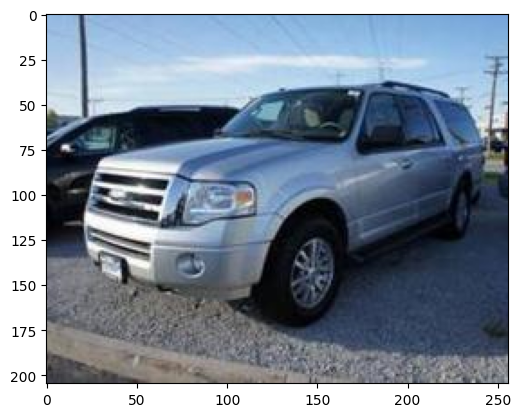

In [8]:
plt.imshow(train.data[1900][0])

In [ ]:
'''sns.set(rc={'figure.figsize':(8,8)})
sns.histplot(train.data[:, 1], binwidth=0.3)'''

# Augmentation


In [9]:
size = 256
train_transform = A.Compose([
    A.LongestMaxSize(size),
    A.PadIfNeeded(size, size),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.PixelDropout(dropout_prob=1e-3),
    A.Normalize(),
    ToTensorV2(),

])
val_transform = A.Compose([ 
    A.LongestMaxSize(size),
    A.PadIfNeeded(size, size), 
    A.VerticalFlip(p=1),
    A.Normalize(), 
    ToTensorV2()])

In [10]:
import gc

In [11]:
gc.collect()

0

# Class balance

In [12]:
def label_weight(label):
    lw = {
        0: 2,
        1: 3,
        2: 8,
        3: 3,
        4: 3,
        5: 2,
        6: 1,
        7: 1,
        8: 8,
        9: 2,
        10: 2
    }

    return lw[label]
class CarsDataset2(torch.utils.data.Dataset):
    def __init__(self, path_to_data, transform=False, train=False):
        self.path_to_data = path_to_data
        self.transform = transform
        self.train = train
        self.data = []
        self._get_data_from_path()
        if self.transform:
            self._add_augmentations()
        #self.data = np.array(self.data)

    def _get_data_from_path(self):
        for folder in tqdm(os.listdir(self.path_to_data)):
            img_folder = os.path.join(self.path_to_data, folder)
            for img in os.listdir(img_folder):
                img = cv2.imread(os.path.join(img_folder, img))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                label = color2label(folder)
                self.data.append([img, label])

    def _add_augmentations(self):
        data = self.data.copy()
        del self.data
        self.data = []
        for img, label in tqdm(data):
            weight = label_weight(label)
            for i in range(weight):
                transformed = self.transform(image=img)
                img_tensor = transformed['image']
                self.data.append((img_tensor, label))
        del data

    def __getitem__(self, idx):
        return self.data[idx]
        
    def __len__(self):
        return len(self.data)

In [13]:
train_dataset = CarsDataset2(path_to_train, transform=train_transform)

100%|██████████| 3802/3802 [00:12<00:00, 297.03it/s]


In [14]:
import gc
gc.collect()

0

In [15]:
len(train_dataset.data)

9219

In [ ]:
'''import seaborn as sns
sns.set(rc={'figure.figsize':(8,8)})
sns.histplot(train_dataset.data[:, 1], binwidth=0.3)'''

In [21]:
train_dataloader = DataLoader(train_dataset, batch_size=16, drop_last=True, shuffle=True)

# Model Training

In [52]:
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)
    
    points = np.array(val_history)
    steps = list(range(0, len(train_history) + 1, int(len(train_history) / len(val_history))))[1:]
    
    plt.scatter(steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')
    
    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [53]:
def train_one_epoch(model, train_dataloader, criterion, optimizer, device="cuda:0"):
    model.train()
    total_loss = 0
    total_accuracy = 0
    n_batchs = 0
    for X_batch, y_batch in train_dataloader:
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)
      y_preds = model(X_batch)
      loss = criterion(y_preds, y_batch)
      total_loss += loss
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      total_accuracy += accuracy_score(y_batch.cpu().numpy(), torch.argmax(y_preds, dim=-1).detach().cpu().numpy())
      n_batchs += 1
    total_accuracy /= n_batchs
    total_loss /= n_batchs
    return total_accuracy, total_loss

def predict(model, val_dataloder, criterion, device="cuda:0"):
    model.eval()
    predicted_classes = torch.tensor([])
    true_classes = torch.tensor([])
    total_loss = 0
    n_batchs = 0
    with torch.no_grad():
      for X_batch, y_batch in tqdm(val_dataloader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_preds = model(X_batch)
        total_loss += criterion(y_preds, y_batch)
        y_batch = y_batch.cpu()
        predicts = model(X_batch)
        predicts = torch.argmax(predicts, dim=1).cpu()
        predicted_classes = torch.cat((predicted_classes, predicts), dim=-1)
        true_classes = torch.cat((true_classes, y_batch), dim=-1)
        n_batchs += 1
      total_loss /= n_batchs
      return total_loss, predicted_classes.numpy(), true_classes.numpy()

def train(model, train_dataloader, val_dataloader, criterion, optimizer, device="cuda:0", n_epochs=10, scheduler=None):
    model.to(device)
    for epoch in tqdm(range(n_epochs)):
        train_acc, train_loss = train_one_epoch(model, train_dataloader, criterion, optimizer, device=device)
        #val_loss, predicted_classes, true_classes = predict(model, val_dataloader, criterion, device=device)
        #val_acc = accuracy_score(true_classes, predicted_classes)
        print(f'Train Loss:{train_loss} Train Accuracy:{train_acc} ')
        #print(f'Val Loss:{val_loss} Val Accuracy:{val_acc} ')
        #del true_classes, predicted_classes

In [54]:
from torchvision.models import efficientnet_b0
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = efficientnet_b0(pretrained=True)
model.classifier = nn.Linear(1280, 11)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [55]:
gc.collect()

28

In [56]:
train(model, train_dataloader, val_dataloader=None, criterion=criterion, optimizer=optimizer, device=device, n_epochs=10)

 10%|█         | 1/10 [00:20<03:05, 20.66s/it]

Train Loss:0.38885027170181274 Train Accuracy:0.8829210069444444 


 20%|██        | 2/10 [00:41<02:47, 20.99s/it]

Train Loss:0.16524571180343628 Train Accuracy:0.9487847222222222 


 30%|███       | 3/10 [01:06<02:40, 22.86s/it]

Train Loss:0.11256102472543716 Train Accuracy:0.9651692708333334 


 40%|████      | 4/10 [01:32<02:24, 24.02s/it]

Train Loss:0.09096566587686539 Train Accuracy:0.9710286458333334 


 50%|█████     | 5/10 [01:58<02:03, 24.63s/it]

Train Loss:0.07900867611169815 Train Accuracy:0.9763454861111112 


 50%|█████     | 5/10 [02:20<02:20, 28.06s/it]


KeyboardInterrupt: 

# Adding MixPrecision, MADGRAD, lr_scheduler

In [22]:
import math
import torch
import torch.optim

from typing import TYPE_CHECKING, Any, Callable, Optional

if TYPE_CHECKING:
    from torch.optim.optimizer import _params_t
else:
    _params_t = Any

class MADGRAD(torch.optim.Optimizer):
    def __init__(
        self, params: _params_t, lr: float = 1e-2, momentum: float = 0.9, 
        weight_decay: float = 0, eps: float = 1e-6, decouple_decay=False,
    ):
        if momentum < 0 or momentum >= 1:
            raise ValueError(f"Momentum {momentum} must be in the range [0,1)")
        if lr <= 0:
            raise ValueError(f"Learning rate {lr} must be positive")
        if weight_decay < 0:
            raise ValueError(f"Weight decay {weight_decay} must be non-negative")
        if eps < 0:
            raise ValueError(f"Eps must be non-negative")

        defaults = dict(lr=lr, eps=eps, momentum=momentum, 
                        weight_decay=weight_decay, decouple_decay=decouple_decay)
        super().__init__(params, defaults)

    @property
    def supports_memory_efficient_fp16(self) -> bool:
        return False

    @property
    def supports_flat_params(self) -> bool:
        return True

    def step(self, closure: Optional[Callable[[], float]] = None) -> Optional[float]:
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        # step counter must be stored in state to ensure correct behavior under
        # optimizer sharding
        if 'k' not in self.state:
            self.state['k'] = torch.tensor([0], dtype=torch.long)
        k = self.state['k'].item()

        for group in self.param_groups:
            eps = group["eps"]
            lr = group["lr"] + eps
            decay = group["weight_decay"]
            momentum = group["momentum"]
            decouple_decay = group["decouple_decay"]

            ck = 1 - momentum
            lamb = lr * math.pow(k + 1, 0.5)

            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                if "grad_sum_sq" not in state:
                    state["grad_sum_sq"] = torch.zeros_like(p.data).detach()
                    state["s"] = torch.zeros_like(p.data).detach()
                    if momentum != 0:
                        state["x0"] = torch.clone(p.data).detach()

                if momentum != 0.0 and grad.is_sparse:
                    raise RuntimeError("momentum != 0 is not compatible with sparse gradients")

                grad_sum_sq = state["grad_sum_sq"]
                s = state["s"]

                # Apply weight decay
                if decay != 0 and not decouple_decay:
                    if grad.is_sparse:
                        raise RuntimeError("weight_decay option is not compatible with sparse gradients")

                    grad.add_(p.data, alpha=decay)

                if grad.is_sparse:
                    grad = grad.coalesce()
                    grad_val = grad._values()

                    p_masked = p.sparse_mask(grad)
                    grad_sum_sq_masked = grad_sum_sq.sparse_mask(grad)
                    s_masked = s.sparse_mask(grad)

                    # Compute x_0 from other known quantities
                    rms_masked_vals = grad_sum_sq_masked._values().pow(1 / 3).add_(eps)
                    x0_masked_vals = p_masked._values().addcdiv(s_masked._values(), rms_masked_vals, value=1)

                    # Dense + sparse op
                    grad_sq = grad * grad
                    grad_sum_sq.add_(grad_sq, alpha=lamb)
                    grad_sum_sq_masked.add_(grad_sq, alpha=lamb)

                    rms_masked_vals = grad_sum_sq_masked._values().pow_(1 / 3).add_(eps)

                    if eps == 0:
                        rms_masked_vals[rms_masked_vals == 0] = float('inf')

                    s.add_(grad, alpha=lamb)
                    s_masked._values().add_(grad_val, alpha=lamb)

                    # update masked copy of p
                    p_kp1_masked_vals = x0_masked_vals.addcdiv(s_masked._values(), rms_masked_vals, value=-1)
                    # Copy updated masked p to dense p using an add operation
                    p_masked._values().add_(p_kp1_masked_vals, alpha=-1)
                    p.data.add_(p_masked, alpha=-1)
                else:
                    if momentum == 0:
                        # Compute x_0 from other known quantities
                        rms = grad_sum_sq.pow(1 / 3).add_(eps)
                        x0 = p.data.addcdiv(s, rms, value=1)
                    else:
                        x0 = state["x0"]

                    # Accumulate second moments
                    grad_sum_sq.addcmul_(grad, grad, value=lamb)
                    rms = grad_sum_sq.pow(1 / 3).add_(eps)

                    if eps == 0:
                        rms[rms == 0] = float('inf')

                    # Update s
                    s.data.add_(grad, alpha=lamb)

                    if decay != 0 and decouple_decay:
                        p_old = p.data.clone()

                    # Step
                    if momentum == 0:
                        p.data.copy_(x0.addcdiv(s, rms, value=-1))
                    else:
                        z = x0.addcdiv(s, rms, value=-1)

                        # p is a moving average of z
                        p.data.mul_(1 - ck).add_(z, alpha=ck)
                    
                    if decay != 0 and decouple_decay:
                        p.data.add_(p_old, alpha=-lr*decay)


        self.state['k'] += 1
        return loss

In [109]:
def train_one_epoch(model, train_dataloader, criterion, optimizer, scaler, device="cuda:0"):
    model.train()
    total_loss = 0
    total_accuracy = 0
    n_batchs = 0
    for X_batch, y_batch in train_dataloader:
      optimizer.zero_grad()
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)
      with torch.autocast(device_type='cuda', dtype=torch.float16):
        y_preds = model(X_batch)
        loss = criterion(y_preds, y_batch)
        total_loss += loss
      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()
      total_accuracy += accuracy_score(y_batch.cpu().numpy(), torch.argmax(y_preds, dim=-1).detach().cpu().numpy())
      n_batchs += 1
    total_accuracy /= n_batchs
    total_loss /= n_batchs
    return total_accuracy, total_loss

def predict(model, val_dataloader, criterion, device="cuda:0"):
    model.eval()
    predicted_classes = torch.tensor([])
    true_classes = torch.tensor([])
    total_loss = 0
    n_batchs = 0
    with torch.no_grad():
      for X_batch, y_batch in tqdm(val_dataloader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        y_preds = model(X_batch)
        total_loss += criterion(y_preds, y_batch)
        y_batch = y_batch.cpu()
        predicts = model(X_batch)
        predicts = torch.argmax(predicts, dim=1).cpu()
        predicted_classes = torch.cat((predicted_classes, predicts), dim=-1)
        true_classes = torch.cat((true_classes, y_batch), dim=-1)
        n_batchs += 1
      total_loss /= n_batchs
      return total_loss, predicted_classes.numpy(), true_classes.numpy()

def train(model, train_dataloader, val_dataloader, criterion, optimizer, scaler, lr_scheduler, device="cuda:0", n_epochs=10):
    model.to(device)
    for epoch in tqdm(range(n_epochs)):
        train_acc, train_loss = train_one_epoch(model, train_dataloader, criterion, optimizer, scaler, device=device)
        if lr_scheduler is not None: 
            lr_scheduler.step()
        #val_loss, predicted_classes, true_classes = predict(model, val_dataloader, criterion, device=device)
        #val_acc = accuracy_score(true_classes, predicted_classes)
        print(f'Train Loss:{train_loss} Train Accuracy:{train_acc}')
        #print(f'Val Loss:{val_loss} Val Accuracy:{val_acc} ')
        #del true_classes, predicted_classes

In [123]:
from torchvision.models import efficientnet_b3
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
model = efficientnet_b0(pretrained=True)
model.classifier = nn.Linear(1280, 11)
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = MADGRAD(model.parameters(), 1e-5)
scaler = GradScaler()
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-8, last_epoch=- 1, verbose=False)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [124]:
train(model, train_dataloader, None, criterion, optimizer, scaler, lr_scheduler, device="cuda:0", n_epochs=10)

 10%|█         | 1/10 [00:22<03:20, 22.30s/it]

Train Loss:0.7438478469848633 Train Accuracy:0.8200954861111112


 20%|██        | 2/10 [00:44<02:57, 22.15s/it]

Train Loss:0.14719146490097046 Train Accuracy:0.958984375


 30%|███       | 3/10 [01:07<02:39, 22.82s/it]

Train Loss:0.08332506567239761 Train Accuracy:0.9781901041666666


 40%|████      | 4/10 [01:30<02:15, 22.63s/it]

Train Loss:0.055331889539957047 Train Accuracy:0.9864366319444444


 50%|█████     | 5/10 [01:54<01:55, 23.03s/it]

Train Loss:0.03788801655173302 Train Accuracy:0.9908854166666666


 60%|██████    | 6/10 [02:16<01:30, 22.71s/it]

Train Loss:0.027390291914343834 Train Accuracy:0.9933810763888888


 70%|███████   | 7/10 [02:40<01:09, 23.17s/it]

Train Loss:0.022198619320988655 Train Accuracy:0.9949001736111112


 80%|████████  | 8/10 [03:02<00:45, 22.75s/it]

Train Loss:0.018278952687978745 Train Accuracy:0.9967447916666666


 90%|█████████ | 9/10 [03:25<00:22, 22.86s/it]

Train Loss:0.016333425417542458 Train Accuracy:0.9970703125


100%|██████████| 10/10 [03:48<00:00, 22.81s/it]

Train Loss:0.015303732827305794 Train Accuracy:0.9968532986111112


# Predict

In [125]:
class CarsDatasetTest(torch.utils.data.Dataset):
    def __init__(self, path_to_data, transform=False, train=False):
        self.path_to_data = path_to_data
        self.transform = transform
        self.train = train
        self.data = []
        self._get_data_from_path()
        if self.transform:
            self._add_augmentations()
        #self.data = np.array(self.data)

    def _get_data_from_path(self):
            for img in tqdm(os.listdir(self.path_to_data)):
                if img[0]!='.':
                    img = cv2.imread(os.path.join(self.path_to_data, img))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    label = 0
                    self.data.append((img, label))

    def _add_augmentations(self):
        data = self.data.copy()
        del self.data
        self.data = []
        for img, label in tqdm(data):
            transformed = self.transform(image=img)
            img_tensor = transformed['image']
            self.data.append((img_tensor, 0))
        del data

    def __getitem__(self, idx):
        return self.data[idx]
        
    def __len__(self):
        return len(self.data)

In [126]:
path_to_test = './public_test'
test_dataset = CarsDatasetTest(path_to_test, transform=val_transform)
test_dataloader = DataLoader(test_dataset, batch_size=16)

100%|██████████| 1436/1436 [00:00<00:00, 2970.11it/s]


In [135]:
def predict(model, val_dataloader, criterion, device="cuda:0"):
    model.eval()
    predicted_classes = torch.tensor([])
    true_classes = torch.tensor([])
    total_loss = 0
    n_batchs = 0
    with torch.no_grad():
      for X_batch, y_batch in tqdm(val_dataloader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        X_batch_hf = torch.flip(X_batch, dims=(2,))
        X_batch_vf = torch.flip(X_batch, dims=(1,))
        y_preds = model(X_batch)
        y_preds += model(X_batch_hf)
        #y_preds += model(X_batch_vf) 
        y_preds /= 2
        total_loss += criterion(y_preds, y_batch)
        y_batch = y_batch.cpu()
        predicts = model(X_batch)
        predicts = torch.argmax(predicts, dim=1).cpu()
        predicted_classes = torch.cat((predicted_classes, predicts), dim=0)
        true_classes = torch.cat((true_classes, y_batch), dim=0)
        n_batchs += 1
      total_loss /= n_batchs
      return total_loss, predicted_classes.numpy(), true_classes.numpy()

In [136]:
total_loss, predicted_classes, true_classes = predict(model, test_dataloader, criterion)

100%|██████████| 90/90 [00:01<00:00, 48.48it/s]


In [137]:
predicted_classes = np.array([label2color(int(preds)) for preds in predicted_classes])

In [138]:
len(test_dataset.data)

1436

In [139]:
imgs=[]
for img in tqdm(os.listdir(path_to_test)):
    if img[0]!='.':
        imgs.append(int(os.path.splitext(img)[0]))


100%|██████████| 1437/1437 [00:00<00:00, 781739.93it/s]


In [140]:
import pandas as pd

In [141]:
test_df = pd.DataFrame(predicted_classes, index=imgs)
test_df

,0
720,Green
860,Orange
683,Cyan
519,Orange
418,Cyan
...,...
1167,Grey
954,Orange
632,Brown
815,Grey


In [143]:
test_df = test_df.sort_index()
test_df = test_df.rename(columns={0: test_df[0][0]})
test_df.drop([0]).reset_index().drop(columns=['index']).to_csv('fifth.csv',index=False)

KeyError: 0

In [89]:
test_df = test_df.sort_index()
test_df = test_df.rename(columns={0: test_df[0][0]})
test_df.drop([0]).reset_index().drop(columns=['index']).to_csv("first.csv", index=False)

In [90]:
print(*predicted_classes)

Green Orange Cyan Orange Cyan Red Orange Green Red White Yellow Yellow Yellow White Blue Green White White Green Brown Red Orange White Orange Orange Orange Yellow White Blue Red Brown Green White Grey Green Yellow Red Orange Orange Yellow White Brown Yellow Orange Yellow Black Grey Orange Red Blue Brown Orange Green Black Red Green Red Yellow White Violet Black Violet Red Black Orange Orange White Blue Cyan Red Yellow White Violet Red Violet Black Violet White Violet Red Orange Red Yellow White White Cyan Red White Black Yellow Violet Grey White Yellow White Green Cyan Green Orange Yellow Yellow Orange Grey Orange Grey Violet Orange Green White Orange White Red Orange Red Green Grey Yellow Orange Red White Yellow Black Black Orange Brown Green White Red Black Orange Violet Green Red Orange Cyan Orange Yellow Blue Blue Red Blue Orange Green Red Green Red Brown Orange Yellow White Red Brown Green Green Black Violet Orange Red Grey Grey Orange Cyan Green Green Orange White Yellow Yellow 

In [49]:
submit = pd.read_csv('sample_submission.csv')
submit_df = submit_df.rename(columns={"corrupted_text": submit_df["corrupted_text"][0]})
submit_df.drop([0]).reset_index().drop(columns=['index']).to_csv(OUTPUT_PATH + "submission_double_bigrams.csv", index=False)



In [50]:
submit

,Red
0,Grey
1,Cyan
2,Black
3,Violet
4,Yellow
...,...
1430,Red
1431,Blue
1432,Yellow
1433,Grey


# Adding TTA

In [ ]:
import torch

In [76]:
def train_one_epoch(model, train_dataloader, criterion, optimizer, scaler, device="cuda:0"):
    model.train()
    total_loss = 0
    total_accuracy = 0
    n_batchs = 0
    for X_batch, y_batch in train_dataloader:
      optimizer.zero_grad()
      X_batch, y_batch = X_batch.to(device), y_batch.to(device)
      with torch.autocast(device_type='cuda', dtype=torch.float16):
        y_preds = model(X_batch)
        loss = criterion(y_preds, y_batch)
        total_loss += loss
      scaler.scale(loss).backward()
      scaler.step(optimizer)
      scaler.update()
      total_accuracy += accuracy_score(y_batch.cpu().numpy(), torch.argmax(y_preds, dim=-1).detach().cpu().numpy())
      n_batchs += 1
    total_accuracy /= n_batchs
    total_loss /= n_batchs
    return total_accuracy, total_loss

def predict(model, val_dataloder, criterion, device="cuda:0"):
    model.eval()
    predicted_classes = torch.tensor([])
    true_classes = torch.tensor([])
    total_loss = 0
    n_batchs = 0
    with torch.no_grad():
      for X_batch, y_batch in tqdm(val_dataloader):
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        X_batch_hf = torch.flip(X_batch, dims=(2,))
        X_batch_vf = torch.flip(X_batch, dims=(1,))
        y_preds = model(X_batch)
        y_preds += model(X_batch_hf)
        y_preds += model(X_batch_vf) 
        y_preds /= 3
        total_loss += criterion(y_preds, y_batch)
        y_batch = y_batch.cpu()
        predicts = model(X_batch)
        predicts = torch.argmax(predicts, dim=1).cpu()
        predicted_classes = torch.cat((predicted_classes, predicts), dim=0)
        true_classes = torch.cat((true_classes, y_batch), dim=0)
        n_batchs += 1
      total_loss /= n_batchs
      return total_loss, predicted_classes.numpy(), true_classes.numpy()

def train(model, train_dataloader, val_dataloader, criterion, optimizer, scaler, lr_scheduler, device="cuda:0", n_epochs=10):
    model.to(device)
    for epoch in tqdm(range(n_epochs)):
        train_acc, train_loss = train_one_epoch(model, train_dataloader, criterion, optimizer, device=device)
        if lr_scheduler is not None: 
            lr_scheduler.step()
        #val_loss, predicted_classes, true_classes = predict(model, val_dataloader, criterion, val_dataloader_hf, device=device)
        #val_acc = accuracy_score(true_classes, predicted_classes)
        print(f'Train Loss:{train_loss} Train Accuracy:{train_acc}')
        #print(f'Val Loss:{val_loss} Val Accuracy:{val_acc} ')
        #del true_classes, predicted_classes

In [ ]:
t = torch.Tensor([
    [[1, 2, 3],
     [4, 5, 6],
     [0, -1, -2]],
    [[7, 8, 9],
     [10, 11, 12],
     [0, -1, -2]],
    [[13, 14, 15],
     [16, 17, 18], 
     [0, -1, -2]],

])

In [ ]:
h_flip = torch.flip(t, dims=(2,))
h_flip

In [ ]:
v_flip = torch.flip(t, dims=(1,))
v_flip

# CrossVal

In [4]:
def color2label(color):
    c2l = {
        'Black': 0,
        'Blue': 1,
        'Brown': 2,
        'Cyan': 3,
        'Green': 4,
        'Grey': 5,
        'Orange': 6,
        'Red': 7,
        'Violet': 8,
        'White': 9,
        'Yellow': 10
    }

    return c2l[color]
def label2color(label):
    c2l = {
        'Black': 0,
        'Blue': 1,
        'Brown': 2,
        'Cyan': 3,
        'Green': 4,
        'Grey': 5,
        'Orange': 6,
        'Red': 7,
        'Violet': 8,
        'White': 9,
        'Yellow': 10
    }
    l2c = {v: k for k, v in c2l.items()}
    return l2c[label]

In [5]:
size = 256
train_transform = A.Compose([
    A.LongestMaxSize(size),
    A.PadIfNeeded(size, size),
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.PixelDropout(dropout_prob=1e-3),
    A.Normalize(),
    ToTensorV2(),

])
val_transform = A.Compose([ 
    A.LongestMaxSize(size),
    A.PadIfNeeded(size, size), 
    A.VerticalFlip(p=1),
    A.Normalize(), 
    ToTensorV2()])

In [6]:
def label_weight(label):
    lw = {
        0: 2,
        1: 3,
        2: 8,
        3: 3,
        4: 3,
        5: 2,
        6: 1,
        7: 1,
        8: 8,
        9: 2,
        10: 2
    }

    return lw[label]
class CarsDataset3(torch.utils.data.Dataset):
    def __init__(self, path_to_data, transform=False, train=False):
        self.path_to_data = path_to_data
        self.transform = transform
        self.train = train
        self.data = []
        self.labels = []
        self._get_data_from_path()
        self.data = np.array(self.data)
        self.labels = np.array(self.labels)

    def _get_data_from_path(self):
        for folder in tqdm(os.listdir(self.path_to_data)):
            img_folder = os.path.join(self.path_to_data, folder)
            for img in os.listdir(img_folder):
                img = cv2.imread(os.path.join(img_folder, img))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                label = color2label(folder)
                size = 256
                transform = A.Compose([
                                        A.LongestMaxSize(size),
                                        A.PadIfNeeded(size, size)])
                transformed = transform(image=img)
                img_tensor = transformed['image']
                self.data.append(img_tensor)
                self.labels.append(label)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
        
    def __len__(self):
        return self.data.shape[0]

In [7]:
path_to_train = './train'
train_dataset = CarsDataset3(path_to_train)

100%|██████████| 11/11 [00:02<00:00,  4.99it/s]


In [8]:
import math
import torch
import torch.optim

from typing import TYPE_CHECKING, Any, Callable, Optional

if TYPE_CHECKING:
    from torch.optim.optimizer import _params_t
else:
    _params_t = Any

class MADGRAD(torch.optim.Optimizer):
    def __init__(
        self, params: _params_t, lr: float = 1e-2, momentum: float = 0.9, 
        weight_decay: float = 0, eps: float = 1e-6, decouple_decay=False,
    ):
        if momentum < 0 or momentum >= 1:
            raise ValueError(f"Momentum {momentum} must be in the range [0,1)")
        if lr <= 0:
            raise ValueError(f"Learning rate {lr} must be positive")
        if weight_decay < 0:
            raise ValueError(f"Weight decay {weight_decay} must be non-negative")
        if eps < 0:
            raise ValueError(f"Eps must be non-negative")

        defaults = dict(lr=lr, eps=eps, momentum=momentum, 
                        weight_decay=weight_decay, decouple_decay=decouple_decay)
        super().__init__(params, defaults)

    @property
    def supports_memory_efficient_fp16(self) -> bool:
        return False

    @property
    def supports_flat_params(self) -> bool:
        return True

    def step(self, closure: Optional[Callable[[], float]] = None) -> Optional[float]:
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        # step counter must be stored in state to ensure correct behavior under
        # optimizer sharding
        if 'k' not in self.state:
            self.state['k'] = torch.tensor([0], dtype=torch.long)
        k = self.state['k'].item()

        for group in self.param_groups:
            eps = group["eps"]
            lr = group["lr"] + eps
            decay = group["weight_decay"]
            momentum = group["momentum"]
            decouple_decay = group["decouple_decay"]

            ck = 1 - momentum
            lamb = lr * math.pow(k + 1, 0.5)

            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                if "grad_sum_sq" not in state:
                    state["grad_sum_sq"] = torch.zeros_like(p.data).detach()
                    state["s"] = torch.zeros_like(p.data).detach()
                    if momentum != 0:
                        state["x0"] = torch.clone(p.data).detach()

                if momentum != 0.0 and grad.is_sparse:
                    raise RuntimeError("momentum != 0 is not compatible with sparse gradients")

                grad_sum_sq = state["grad_sum_sq"]
                s = state["s"]

                # Apply weight decay
                if decay != 0 and not decouple_decay:
                    if grad.is_sparse:
                        raise RuntimeError("weight_decay option is not compatible with sparse gradients")

                    grad.add_(p.data, alpha=decay)

                if grad.is_sparse:
                    grad = grad.coalesce()
                    grad_val = grad._values()

                    p_masked = p.sparse_mask(grad)
                    grad_sum_sq_masked = grad_sum_sq.sparse_mask(grad)
                    s_masked = s.sparse_mask(grad)

                    # Compute x_0 from other known quantities
                    rms_masked_vals = grad_sum_sq_masked._values().pow(1 / 3).add_(eps)
                    x0_masked_vals = p_masked._values().addcdiv(s_masked._values(), rms_masked_vals, value=1)

                    # Dense + sparse op
                    grad_sq = grad * grad
                    grad_sum_sq.add_(grad_sq, alpha=lamb)
                    grad_sum_sq_masked.add_(grad_sq, alpha=lamb)

                    rms_masked_vals = grad_sum_sq_masked._values().pow_(1 / 3).add_(eps)

                    if eps == 0:
                        rms_masked_vals[rms_masked_vals == 0] = float('inf')

                    s.add_(grad, alpha=lamb)
                    s_masked._values().add_(grad_val, alpha=lamb)

                    # update masked copy of p
                    p_kp1_masked_vals = x0_masked_vals.addcdiv(s_masked._values(), rms_masked_vals, value=-1)
                    # Copy updated masked p to dense p using an add operation
                    p_masked._values().add_(p_kp1_masked_vals, alpha=-1)
                    p.data.add_(p_masked, alpha=-1)
                else:
                    if momentum == 0:
                        # Compute x_0 from other known quantities
                        rms = grad_sum_sq.pow(1 / 3).add_(eps)
                        x0 = p.data.addcdiv(s, rms, value=1)
                    else:
                        x0 = state["x0"]

                    # Accumulate second moments
                    grad_sum_sq.addcmul_(grad, grad, value=lamb)
                    rms = grad_sum_sq.pow(1 / 3).add_(eps)

                    if eps == 0:
                        rms[rms == 0] = float('inf')

                    # Update s
                    s.data.add_(grad, alpha=lamb)

                    if decay != 0 and decouple_decay:
                        p_old = p.data.clone()

                    # Step
                    if momentum == 0:
                        p.data.copy_(x0.addcdiv(s, rms, value=-1))
                    else:
                        z = x0.addcdiv(s, rms, value=-1)

                        # p is a moving average of z
                        p.data.mul_(1 - ck).add_(z, alpha=ck)
                    
                    if decay != 0 and decouple_decay:
                        p.data.add_(p_old, alpha=-lr*decay)


        self.state['k'] += 1
        return loss

In [9]:
def train_one_epoch(model, train_dataloader, criterion, optimizer, scaler, device="cuda:0"):
    model.train()
    total_loss = 0
    total_accuracy = 0
    n_batchs = 0
    for X_batch, y_batch in train_dataloader:
        optimizer.zero_grad()
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        with torch.autocast(device_type='cuda', dtype=torch.float16):
            y_preds = model(X_batch)
            loss = criterion(y_preds, y_batch)
            total_loss += loss
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        total_accuracy += accuracy_score(y_batch.cpu().numpy(), torch.argmax(y_preds, dim=-1).detach().cpu().numpy())
        n_batchs += 1
    total_accuracy /= n_batchs
    total_loss /= n_batchs
    return total_accuracy, total_loss

def predict(model, val_dataloader, criterion, device="cuda:0"):
    model.eval()
    predicted_classes = torch.tensor([])
    true_classes = torch.tensor([])
    total_loss = 0
    n_batchs = 0
    with torch.no_grad():
        for X_batch, y_batch in val_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            y_preds = model(X_batch)
            total_loss += criterion(y_preds, y_batch)
            y_batch = y_batch.cpu()
            predicts = model(X_batch)
            predicts = torch.argmax(predicts, dim=1).cpu()
            predicted_classes = torch.cat((predicted_classes, predicts), dim=-1)
            true_classes = torch.cat((true_classes, y_batch), dim=-1)
            n_batchs += 1
    total_loss /= n_batchs
    return total_loss, predicted_classes.numpy(), true_classes.numpy()

def train(model, train_dataloader, val_dataloader, criterion, optimizer, scaler, lr_scheduler, device="cuda:0", n_epochs=10):
    model.to(device)
    for epoch in tqdm(range(n_epochs)):
        train_acc, train_loss = train_one_epoch(model, train_dataloader, criterion, optimizer, scaler, device=device)
        if lr_scheduler is not None: 
            lr_scheduler.step()
        val_loss, predicted_classes, true_classes = predict(model, val_dataloader, criterion, device=device)
        val_acc = accuracy_score(true_classes, predicted_classes)
        print(f'Train Loss:{train_loss} Train Accuracy:{train_acc}')
        print(f'Val Loss:{val_loss} Val Accuracy:{val_acc} ')
        del true_classes, predicted_classes

In [10]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from torchvision.models import efficientnet_b1
import gc
train_transform = A.Compose([
    A.VerticalFlip(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.PixelDropout(dropout_prob=1e-3),
    A.Normalize(),
    ToTensorV2(),

])
val_transform = A.Compose([
    A.Normalize(), 
    ToTensorV2()])
class cv_dataset(torch.utils.data.Dataset):
    def __init__(self, data, labels, transform, train=False):
        self.data = data
        self.labels = labels
        self.transform  = transform
        self.train = train
        self._add_augmentations()
        
    def _add_augmentations(self):
        data = self.data.copy()
        labels = self.labels.copy()
        del self.data, self.labels
        self.data = []
        self.labels = []
        for i in tqdm(range(len(data))):
            img = data[i]
            label = labels[i]
            weight = label_weight(label) if self.train else 1
            for j in range(weight):
                transformed = self.transform(image=img)
                img_tensor = transformed['image']
                self.data.append(img_tensor)
                self.labels.append(label)
                
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
    
def crossval(dataset, train_transform=train_transform, val_transform=val_transform, n_folds=4):
    kf = KFold(n_splits=n_folds, random_state=42, shuffle=True)
    kf.get_n_splits(dataset.data)
    i = 0
    for train_index, test_index in kf.split(dataset.data):
        X_train, y_train = dataset[train_index]
        X_test, y_test = dataset[test_index]
        fold_train = cv_dataset(X_train, y_train, train_transform, train=True)
        fold_val = cv_dataset(X_test, y_test, val_transform, train=False)
        train_dataloader = DataLoader(fold_train, batch_size=16, drop_last=True, shuffle=True)
        val_dataloader = DataLoader(fold_val , batch_size=16, drop_last=True, shuffle=True)
        device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
        model = efficientnet_b1(weights='IMAGENET1K_V2')
        model.classifier = nn.Linear(1280, 11)
        model.to(device)
        criterion = nn.CrossEntropyLoss()
        optimizer = MADGRAD(model.parameters(), 1e-5)
        scaler = GradScaler()
        lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10, eta_min=5e-9, last_epoch=- 1, verbose=False)
        train(model, train_dataloader, val_dataloader, criterion, optimizer, scaler, lr_scheduler, device="cuda:0", n_epochs=8)
        with open(f'./models/model_{i}.pkl', 'wb') as f:
            pickle.dump(model, f)
        del model, train_dataloader, val_dataloader, fold_train, fold_val
        gc.collect()
        torch.cuda.empty_cache
        i += 1

In [11]:
crossval(train_dataset, train_transform=train_transform, val_transform=val_transform, n_folds=8)

 12%|█▎        | 1/8 [00:27<03:13, 27.58s/it]

Train Loss:1.2409114837646484 Train Accuracy:0.6840069860279441
Val Loss:6.5976128578186035 Val Accuracy:0.9676724137931034 


 12%|█▎        | 1/8 [00:31<03:42, 31.81s/it]


KeyboardInterrupt: 

In [23]:
import gc
gc.collect()

64

In [ ]:
de

In [24]:
torch.cuda.empty_cache

<function torch.cuda.memory.empty_cache() -> None>

In [25]:
test_transform = A.Compose([
                        A.LongestMaxSize(size),
                        A.PadIfNeeded(size, size),
                        A.Normalize(),
                        ToTensorV2(),
])
class CarsDatasetTest(torch.utils.data.Dataset):
    def __init__(self, path_to_data, transform=False, train=False):
        self.path_to_data = path_to_data
        self.transform = transform
        self.train = train
        self.data = []
        self.labels = []
        self._get_data_from_path()
        if self.transform:
            self._add_augmentations()
        #self.data = np.array(self.data)

    def _get_data_from_path(self):
            for img in tqdm(os.listdir(self.path_to_data)):
                if img[0]!='.':
                    img = cv2.imread(os.path.join(self.path_to_data, img))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    label = 0
                    self.data.append(img)
                    self.labels.append(label)

    def _add_augmentations(self):
        data = self.data.copy()
        del self.data
        self.data = []
        for img in tqdm(data):
            transformed = self.transform(image=img)
            img_tensor = transformed['image']
            self.data.append(img_tensor)
        del data

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
        
    def __len__(self):
        return len(self.data)

In [26]:
path_to_test = './public_test'
test_dataset = CarsDatasetTest(path_to_test, transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=16)

100%|██████████| 1436/1436 [00:00<00:00, 3129.59it/s]


In [27]:
def cv_predict(model, val_dataloader, criterion=None,device="cuda:0"):
    model.eval()
    predicted_classes = torch.tensor([])
    total_loss = 0
    n_batchs = 0
    first = True
    with torch.no_grad():
        for X_batch, y_batch in val_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            #y_preds = model(X_batch)
            #total_loss += criterion(y_preds, y_batch)
            #y_batch = y_batch.cpu()
            if first:
                predicted_probas = F.softmax(model(X_batch), dim=1).cpu()
                first = False
            else:
                probas = F.softmax(model(X_batch), dim=1).cpu()
                predicted_probas = torch.cat((predicted_probas, probas), dim=0)
    return predicted_probas

In [28]:
total_probas = torch.zeros((len(test_dataset.data), 11))
for  i in range(4):
    with open(f'./models/model_{i}.pkl', 'rb') as f:
        model  = pickle.load(f)
        total_probas += cv_predict(model, test_dataloader)

In [29]:
total_probas /= 6
predicted_classes = torch.argmax(total_probas, dim=1)

In [30]:
predicted_classes = np.array([label2color(int(preds)) for preds in predicted_classes])

In [31]:
len(test_dataset.data)

1436

In [33]:
imgs=[]
for img in tqdm(os.listdir(path_to_test)):
    if img[0]!='.':
        imgs.append(int(os.path.splitext(img)[0]))


100%|██████████| 1437/1437 [00:00<00:00, 663644.00it/s]


In [34]:
import pandas as pd

In [38]:
test_df = pd.DataFrame(predicted_classes, index=imgs)
test_df

,0
720,Green
860,Orange
683,Cyan
519,Orange
418,Cyan
...,...
1167,Grey
954,Orange
632,Brown
815,Grey


In [41]:
test_df.loc[720]

0    Green
Name: 720, dtype: object

In [42]:
test_df = test_df.sort_index()
test_df = test_df.rename(columns={0: test_df[0][0]})
test_df.drop([0]).reset_index().drop(columns=['index']).to_csv('cv2.csv',index=False)

In [58]:
test_df = pd.DataFrame(predicted_classes, index=imgs)
test_df.loc[720].values[0]

'Green'

# Добавим предсказания на паблике и обучимся еще раз

In [62]:
test_transform = A.Compose([
                        A.LongestMaxSize(size),
                        A.PadIfNeeded(size, size),
])
class CarsDatasetTest2(torch.utils.data.Dataset):
    def __init__(self, path_to_data, test_df=test_df, transform=False, train=False):
        self.path_to_data = path_to_data
        self.transform = transform
        self.train = train
        self.data = []
        self.labels = []
        self.test_df = test_df
        self._get_data_from_path()
        if self.transform:
            self._add_augmentations()
        self.data = np.array(self.data)
        self.labels = np.array(self.labels)

    def _get_data_from_path(self):
            for img in tqdm(os.listdir(self.path_to_data)):
                if img[0]!='.':
                    label = color2label(test_df.loc[int(img[:-4])].values[0])
                    img = cv2.imread(os.path.join(self.path_to_data, img))
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    self.data.append(img)
                    self.labels.append(label)

    def _add_augmentations(self):
        data = self.data.copy()
        del self.data
        self.data = []
        for img in tqdm(data):
            transformed = self.transform(image=img)
            img_tensor = transformed['image']
            self.data.append(img_tensor)
        del data

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
        
    def __len__(self):
        return len(self.data)

In [63]:
additive = CarsDatasetTest2(path_to_test, test_df, test_transform)

100%|██████████| 1436/1436 [00:00<00:00, 11546.58it/s]


In [68]:
train_dataset.data = np.concatenate((train_dataset.data, additive.data), axis=0)

In [69]:
train_dataset.labels = np.concatenate((train_dataset.labels, additive.labels), axis=0)

In [71]:
train_dataset.labels.shape

(5238,)

In [72]:
crossval(train_dataset, train_transform=train_transform, val_transform=val_transform, n_folds=4)

 12%|█▎        | 1/8 [00:33<03:57, 33.93s/it]

Train Loss:1.0604500770568848 Train Accuracy:0.7379132231404959
Val Loss:14.404203414916992 Val Accuracy:0.9645061728395061 


 25%|██▌       | 2/8 [01:07<03:24, 34.00s/it]

Train Loss:0.19124072790145874 Train Accuracy:0.9506198347107438
Val Loss:8.501412391662598 Val Accuracy:0.9699074074074074 


 38%|███▊      | 3/8 [01:41<02:48, 33.73s/it]

Train Loss:0.11620094627141953 Train Accuracy:0.9683884297520661
Val Loss:6.2779154777526855 Val Accuracy:0.9768518518518519 


 50%|█████     | 4/8 [02:14<02:14, 33.64s/it]

Train Loss:0.07960959523916245 Train Accuracy:0.9802685950413224
Val Loss:4.902996063232422 Val Accuracy:0.9807098765432098 


 62%|██████▎   | 5/8 [02:48<01:41, 33.74s/it]

Train Loss:0.06261789798736572 Train Accuracy:0.9829545454545454
Val Loss:5.903212547302246 Val Accuracy:0.9760802469135802 


 75%|███████▌  | 6/8 [03:22<01:07, 33.87s/it]

Train Loss:0.05166732892394066 Train Accuracy:0.9880165289256199
Val Loss:4.587480068206787 Val Accuracy:0.9861111111111112 


 88%|████████▊ | 7/8 [03:56<00:33, 33.92s/it]

Train Loss:0.03883935138583183 Train Accuracy:0.990909090909091
Val Loss:5.010487079620361 Val Accuracy:0.9807098765432098 


100%|██████████| 8/8 [04:30<00:00, 33.83s/it]

Train Loss:0.03504720702767372 Train Accuracy:0.9916322314049587
Val Loss:5.269010543823242 Val Accuracy:0.9783950617283951 



 12%|█▎        | 1/8 [00:33<03:51, 33.05s/it]

Train Loss:1.0588486194610596 Train Accuracy:0.7378300330033003
Val Loss:15.764690399169922 Val Accuracy:0.9537037037037037 


 25%|██▌       | 2/8 [01:05<03:17, 32.95s/it]

Train Loss:0.19273273646831512 Train Accuracy:0.9479166666666666
Val Loss:8.102088928222656 Val Accuracy:0.9745370370370371 


 38%|███▊      | 3/8 [01:38<02:44, 32.90s/it]

Train Loss:0.11354022473096848 Train Accuracy:0.9698844884488449
Val Loss:7.670165061950684 Val Accuracy:0.9745370370370371 


 50%|█████     | 4/8 [02:11<02:11, 32.86s/it]

Train Loss:0.08076518028974533 Train Accuracy:0.9791666666666666
Val Loss:6.108611583709717 Val Accuracy:0.9776234567901234 


 62%|██████▎   | 5/8 [02:44<01:39, 33.01s/it]

Train Loss:0.06117308512330055 Train Accuracy:0.9845297029702971
Val Loss:7.90041446685791 Val Accuracy:0.9691358024691358 


 75%|███████▌  | 6/8 [03:17<01:05, 32.97s/it]

Train Loss:0.04667002707719803 Train Accuracy:0.9884488448844885
Val Loss:6.585562229156494 Val Accuracy:0.9760802469135802 


 88%|████████▊ | 7/8 [03:50<00:32, 32.95s/it]

Train Loss:0.039370615035295486 Train Accuracy:0.9914397689768977
Val Loss:5.527088642120361 Val Accuracy:0.9807098765432098 


100%|██████████| 8/8 [04:23<00:00, 32.94s/it]

Train Loss:0.03343876078724861 Train Accuracy:0.991852310231023
Val Loss:5.915024757385254 Val Accuracy:0.9814814814814815 



 12%|█▎        | 1/8 [00:32<03:48, 32.60s/it]

Train Loss:1.0087181329727173 Train Accuracy:0.7554661716171617
Val Loss:13.897858619689941 Val Accuracy:0.9614197530864198 


 25%|██▌       | 2/8 [01:05<03:17, 32.86s/it]

Train Loss:0.18080070614814758 Train Accuracy:0.9531765676567657
Val Loss:7.152127742767334 Val Accuracy:0.9729938271604939 


 38%|███▊      | 3/8 [01:38<02:44, 32.96s/it]

Train Loss:0.1096876710653305 Train Accuracy:0.9704001650165016
Val Loss:7.50783109664917 Val Accuracy:0.9675925925925926 


 50%|█████     | 4/8 [02:12<02:12, 33.14s/it]

Train Loss:0.07535697519779205 Train Accuracy:0.9795792079207921
Val Loss:4.969727993011475 Val Accuracy:0.9783950617283951 


 62%|██████▎   | 5/8 [02:45<01:39, 33.31s/it]

Train Loss:0.06066079065203667 Train Accuracy:0.9836014851485149
Val Loss:5.3984174728393555 Val Accuracy:0.9760802469135802 


 75%|███████▌  | 6/8 [03:19<01:07, 33.57s/it]

Train Loss:0.050443701446056366 Train Accuracy:0.9867986798679867
Val Loss:5.236442565917969 Val Accuracy:0.9768518518518519 


 88%|████████▊ | 7/8 [03:53<00:33, 33.67s/it]

Train Loss:0.04113917425274849 Train Accuracy:0.989480198019802
Val Loss:4.687049388885498 Val Accuracy:0.9768518518518519 


100%|██████████| 8/8 [04:26<00:00, 33.36s/it]

Train Loss:0.032948993146419525 Train Accuracy:0.9929867986798679
Val Loss:4.51701545715332 Val Accuracy:0.9822530864197531 



 12%|█▎        | 1/8 [00:33<03:51, 33.10s/it]

Train Loss:1.0059667825698853 Train Accuracy:0.7578517587939698
Val Loss:13.253839492797852 Val Accuracy:0.9567901234567902 


 25%|██▌       | 2/8 [01:07<03:22, 33.69s/it]

Train Loss:0.17220428586006165 Train Accuracy:0.9566582914572864
Val Loss:7.183732986450195 Val Accuracy:0.9753086419753086 


 38%|███▊      | 3/8 [01:41<02:49, 33.92s/it]

Train Loss:0.09996601194143295 Train Accuracy:0.9728852596314908
Val Loss:6.013702869415283 Val Accuracy:0.9791666666666666 


 50%|█████     | 4/8 [02:15<02:16, 34.01s/it]

Train Loss:0.07485343515872955 Train Accuracy:0.980108877721943
Val Loss:5.891217231750488 Val Accuracy:0.9783950617283951 


 62%|██████▎   | 5/8 [02:49<01:42, 34.08s/it]

Train Loss:0.05617392808198929 Train Accuracy:0.9842964824120602
Val Loss:5.656332492828369 Val Accuracy:0.9799382716049383 


 75%|███████▌  | 6/8 [03:22<01:07, 33.72s/it]

Train Loss:0.04336482658982277 Train Accuracy:0.9892169179229481
Val Loss:5.957456588745117 Val Accuracy:0.9837962962962963 


 88%|████████▊ | 7/8 [03:55<00:33, 33.40s/it]

Train Loss:0.037076015025377274 Train Accuracy:0.9912060301507538
Val Loss:5.67193603515625 Val Accuracy:0.9814814814814815 


100%|██████████| 8/8 [04:28<00:00, 33.61s/it]

Train Loss:0.03274580091238022 Train Accuracy:0.9918341708542714
Val Loss:5.718727111816406 Val Accuracy:0.9814814814814815 


In [73]:
path_to_test = './public_test'
test_dataset = CarsDatasetTest(path_to_test, transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=16)

100%|██████████| 1436/1436 [00:00<00:00, 10564.46it/s]


In [74]:
def cv_predict(model, val_dataloader, criterion=None,device="cuda:0"):
    model.eval()
    predicted_classes = torch.tensor([])
    total_loss = 0
    n_batchs = 0
    first = True
    with torch.no_grad():
        for X_batch, y_batch in val_dataloader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            #y_preds = model(X_batch)
            #total_loss += criterion(y_preds, y_batch)
            #y_batch = y_batch.cpu()
            if first:
                predicted_probas = F.softmax(model(X_batch), dim=1).cpu()
                first = False
            else:
                probas = F.softmax(model(X_batch), dim=1).cpu()
                predicted_probas = torch.cat((predicted_probas, probas), dim=0)
    return predicted_probas

In [75]:
total_probas = torch.zeros((len(test_dataset.data), 11))
for  i in range(4):
    with open(f'./models/model_{i}.pkl', 'rb') as f:
        model  = pickle.load(f)
        total_probas += cv_predict(model, test_dataloader)

RuntimeError: Given groups=1, weight of size [32, 3, 3, 3], expected input[16, 256, 256, 3] to have 3 channels, but got 256 channels instead

In [29]:
total_probas /= 4
predicted_classes = torch.argmax(total_probas, dim=1)

In [30]:
predicted_classes = np.array([label2color(int(preds)) for preds in predicted_classes])

In [31]:
len(test_dataset.data)

1436

In [33]:
imgs=[]
for img in tqdm(os.listdir(path_to_test)):
    if img[0]!='.':
        imgs.append(int(os.path.splitext(img)[0]))


100%|██████████| 1437/1437 [00:00<00:00, 663644.00it/s]


In [34]:
import pandas as pd

In [38]:
test_df = pd.DataFrame(predicted_classes, index=imgs)
test_df

,0
720,Green
860,Orange
683,Cyan
519,Orange
418,Cyan
...,...
1167,Grey
954,Orange
632,Brown
815,Grey


In [41]:
test_df.loc[720]

0    Green
Name: 720, dtype: object

In [42]:
test_df = test_df.sort_index()
test_df = test_df.rename(columns={0: test_df[0][0]})
test_df.drop([0]).reset_index().drop(columns=['index']).to_csv('cv2.csv',index=False)